In [1]:
!pip install kaggle


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!kaggle datasets download -d rm1000/lung-cancer-histopathological-images

Dataset URL: https://www.kaggle.com/datasets/rm1000/lung-cancer-histopathological-images
License(s): CC-BY-SA-4.0
lung-cancer-histopathological-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile
import os

# Path to the downloaded dataset zip file
dataset_zip = 'lung-cancer-histopathological-images.zip'

# Extract the dataset
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall('LungCancer')

print("Dataset extracted successfully.")


Dataset extracted successfully.


In [4]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score

In [5]:
# Check GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [6]:
# Common settings
base_dir = 'LungCancer'
img_height, img_width = 150, 150
batch_size = 32

def random_contrast(image):
    """Apply random contrast to the input image"""
    contrast_factor = tf.random.uniform([], 0.5, 1.5)
    image = tf.image.adjust_contrast(image, contrast_factor)
    return image

# Data generators setup
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=random_contrast
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


# Data generators
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.020439966..1.0031674].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.020439966..1.0031674].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09711706..0.995401].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09711706..0.995401].


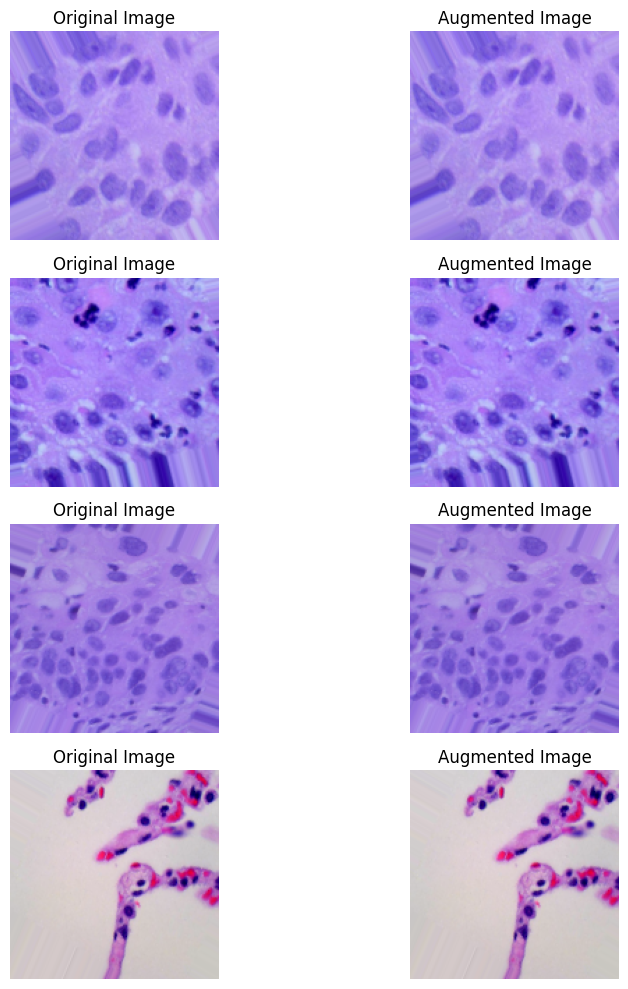

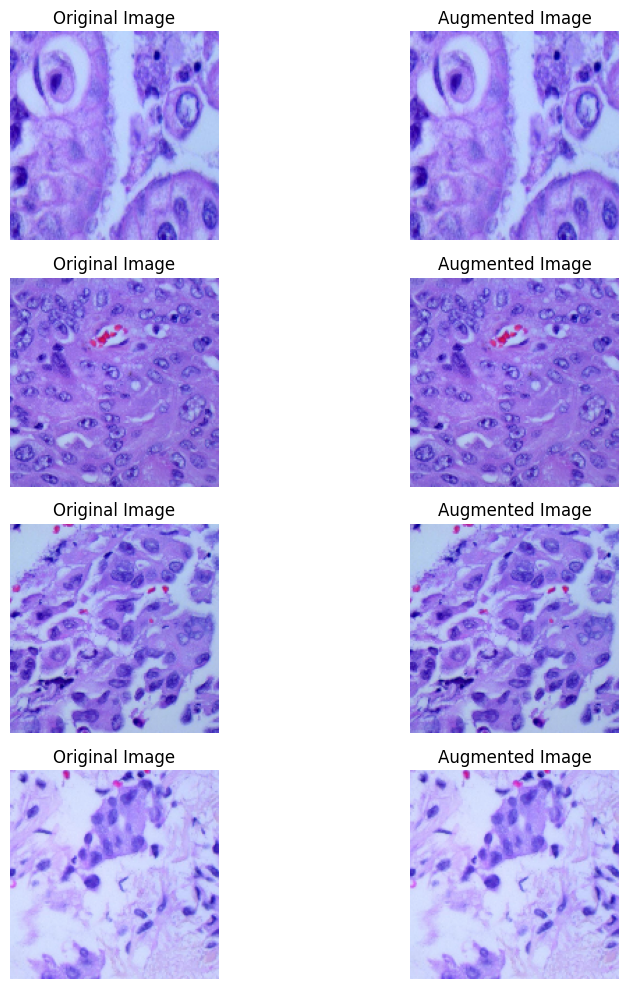

In [7]:
def display_images(generator, num_images=4):
    fig, axs = plt.subplots(nrows=num_images, ncols=2, figsize=(10, 10))
    axs = axs.flatten()

    for i in range(num_images):
        img, label = next(generator)
        axs[2*i].imshow(img[0])
        axs[2*i].set_title('Original Image')
        axs[2*i].axis('off')

        axs[2*i+1].imshow(img[0])
        axs[2*i+1].set_title('Augmented Image')
        axs[2*i+1].axis('off')

    plt.tight_layout()
    plt.show()

# Display original and augmented images for training data
display_images(train_generator)

# Display original and augmented images for validation data
display_images(validation_generator)

In [8]:
# Function to get image shapes
def get_image_shapes(generator):
    shapes = []
    for i in range(len(generator)):
        images, _ = generator[i]
        for img in images:
            shapes.append(img.shape)
    return np.array(shapes)

# Get shapes for training and validation sets
train_shapes = get_image_shapes(train_generator)
validation_shapes = get_image_shapes(validation_generator)

# Calculate statistics
def calculate_statistics(shapes):
    unique_shapes = np.unique(shapes, axis=0)
    min_dimensions = np.min(shapes, axis=0)
    max_dimensions = np.max(shapes, axis=0)
    mean_dimensions = np.mean(shapes, axis=0)
    return unique_shapes, min_dimensions, max_dimensions, mean_dimensions

train_unique_shapes, train_min_dimensions, train_max_dimensions, train_mean_dimensions = calculate_statistics(train_shapes)
validation_unique_shapes, validation_min_dimensions, validation_max_dimensions, validation_mean_dimensions = calculate_statistics(validation_shapes)

# Print statistics
print("Training Dataset:")
print(f"Number of images: {len(train_shapes)}")
print(f"Unique shapes: {train_unique_shapes}")
print(f"Min dimensions: {train_min_dimensions}")
print(f"Max dimensions: {train_max_dimensions}")
print(f"Mean dimensions: {train_mean_dimensions}")

print("\nValidation Dataset:")
print(f"Number of images: {len(validation_shapes)}")
print(f"Unique shapes: {validation_unique_shapes}")
print(f"Min dimensions: {validation_min_dimensions}")
print(f"Max dimensions: {validation_max_dimensions}")
print(f"Mean dimensions: {validation_mean_dimensions}")

Training Dataset:
Number of images: 12000
Unique shapes: [[150 150   3]]
Min dimensions: [150 150   3]
Max dimensions: [150 150   3]
Mean dimensions: [150. 150.   3.]

Validation Dataset:
Number of images: 3000
Unique shapes: [[150 150   3]]
Min dimensions: [150 150   3]
Max dimensions: [150 150   3]
Mean dimensions: [150. 150.   3.]


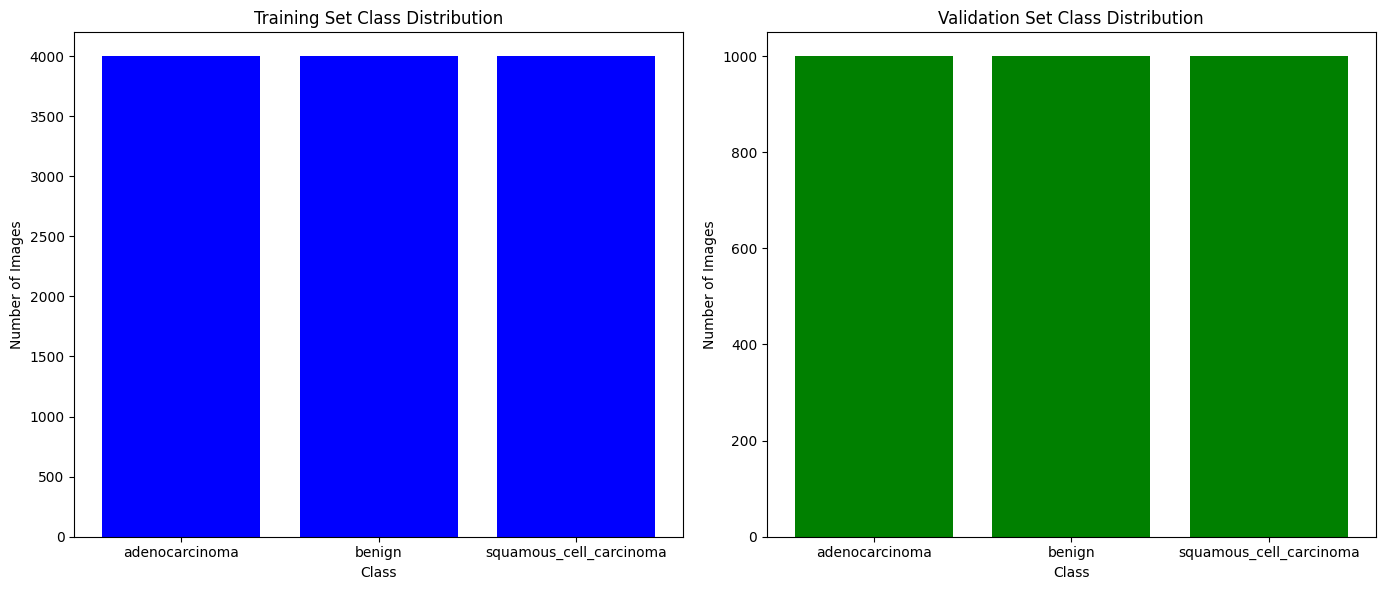

In [10]:
# Get class labels from the generator
class_labels = list(train_generator.class_indices.keys())

# Count images per class
train_counts = np.zeros(len(class_labels))
validation_counts = np.zeros(len(class_labels))
for i, label in enumerate(train_generator.classes):
    train_counts[label] += 1
for i, label in enumerate(validation_generator.classes):
    validation_counts[label] += 1

# Plot distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].bar(class_labels, train_counts, color='blue')
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Images')
ax[1].bar(class_labels, validation_counts, color='green')
ax[1].set_title('Validation Set Class Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of Images')
plt.tight_layout()
plt.show()

In [11]:
# Model creation using MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

# Fine-tuning setup
for layer in base_model.layers[-30:]:
    layer.trainable = True



/var/folders/sm/n0tyhvz11j72ff1yj0tlvywh0000gn/T/ipykernel_6412/2466868762.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


In [12]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 75, 75,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 75, 75,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 75, 75,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 75, 75,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 75, 75,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 75, 75,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 77, 77,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 38, 38,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 38, 38,    │      2,304 │ block_1_depthwis

 Total params: 4,096,067 (15.63 MB)

 Trainable params: 4,061,955 (15.50 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [13]:
# Compile model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Training setup
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [14]:
# Train model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50


/Users/kalariyatamanna/Documents/college/SEM5/SGP/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 909s 2s/step - accuracy: 0.8334 - loss: 0.3978 - val_accuracy: 0.6333 - val_loss: 2.5945
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1010s 3s/step - accuracy: 0.9664 - loss: 0.0988 - val_accuracy: 0.7720 - val_loss: 1.1461
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1468s 4s/step - accuracy: 0.9792 - loss: 0.0577 - val_accuracy: 0.8600 - val_loss: 0.7205
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1052s 3s/step - accuracy: 0.9872 - loss: 0.0393 - val_accuracy: 0.9433 - val_loss: 0.2793
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 813s 2s/step - accuracy: 0.9895 - loss: 0.0349 - val_accuracy: 0.9107 - val_loss: 0.4336
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 648s 2s/step - accuracy: 0.9927 - loss: 0.0203 - val_accuracy: 0.9753 - val_loss: 0.1213
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1053s 3s/step - accuracy: 0.9932 - loss: 0.0208 - val_accuracy: 0.9693 - val_loss: 0.1711
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1392s 4s/step - accuracy: 0.9945 - loss: 0.0140 - val_accuracy: 

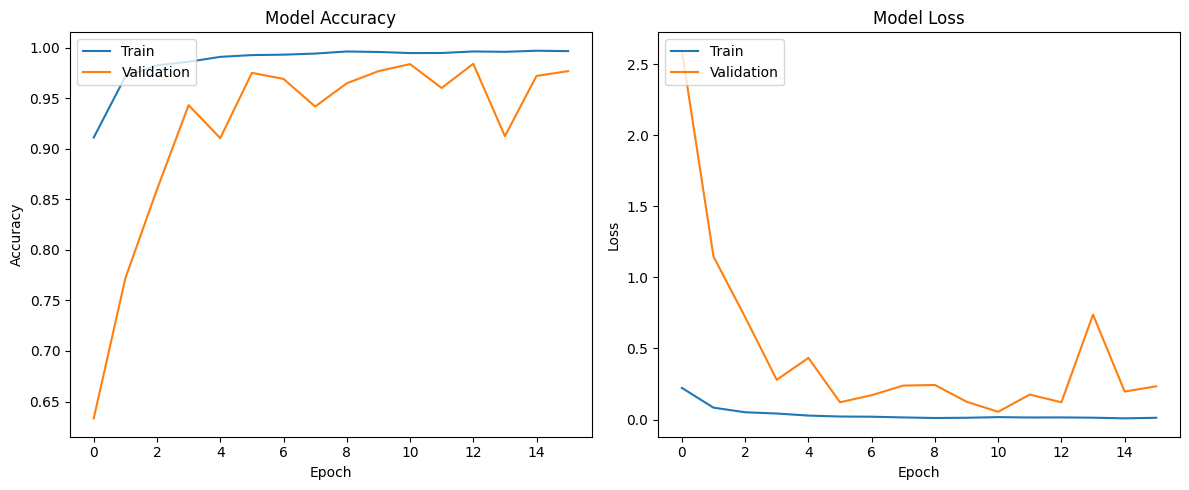

In [15]:
def plot_training_history(history):
    """Plot training and validation metrics"""
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)


In [16]:
# Print final metrics
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")


Final Training Accuracy: 0.9968
Final Validation Accuracy: 0.9770


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


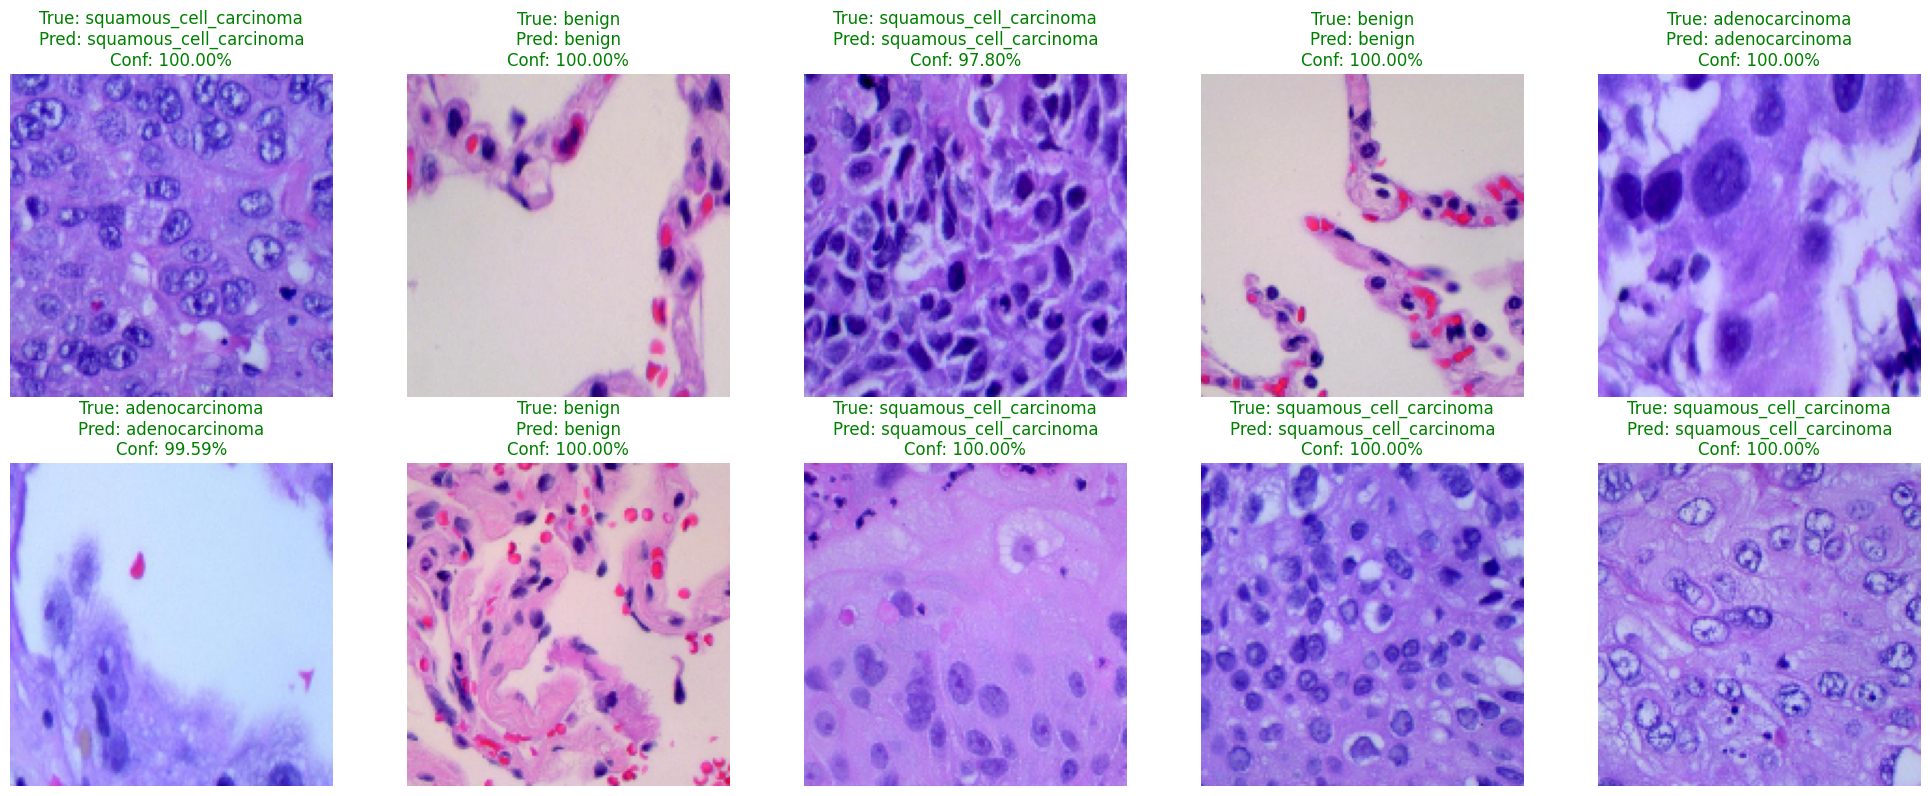

In [17]:
def plot_predictions_with_confidence(model, validation_generator, num_images=10):
    """Plot predictions with confidence scores"""
    class_indices = validation_generator.class_indices
    class_names = list(class_indices.keys())
    
    validation_generator.reset()
    X_val, y_val = next(validation_generator)
    for i in range(1, validation_generator.samples // validation_generator.batch_size):
        img, label = next(validation_generator)
        X_val = np.append(X_val, img, axis=0)
        y_val = np.append(y_val, label, axis=0)
    
    indices = random.sample(range(len(X_val)), num_images)
    selected_images = X_val[indices]
    selected_labels = y_val[indices]
    
    predictions = model.predict(selected_images)
    predicted_classes = np.argmax(predictions, axis=1)
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    for i, idx in enumerate(indices):
        axes[i].imshow(selected_images[i])
        axes[i].axis('off')
        true_label = class_names[np.argmax(selected_labels[i])]
        pred_label = class_names[predicted_classes[i]]
        confidence = predictions[i][predicted_classes[i]] * 100
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}%', 
                         color=color, fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Evaluate model predictions
plot_predictions_with_confidence(model, validation_generator, num_images=10)


94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 598ms/step
Confusion Matrix:


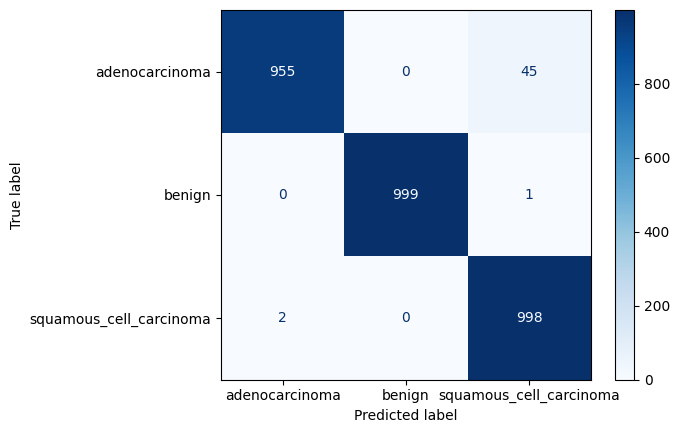

In [18]:
# Generate confusion matrix
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
class_names = list(validation_generator.class_indices.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [19]:
# Calculate and print recall
recall = recall_score(y_true, y_pred_classes, average='macro')
print(f"Recall: {recall:.4f}")

Recall: 0.9840


In [24]:
# Save the trained model
try:
    model.save('lung_cancer_mobilenet.h5')
    print("Model successfully saved as 'lung_cancer_mobilenet.h5'")
    
    # Verify the file was created
    if os.path.exists('lung_cancer_mobilenet.h5'):
        print(f"Verified: Model file exists at {os.path.abspath('lung_cancer_mobilenet.h5')}")
        print(f"File size: {os.path.getsize('lung_cancer_mobilenet.h5') / (1024*1024):.2f} MB")
except Exception as e:
    print(f"Error saving model: {e}")

Model successfully saved as 'lung_cancer_mobilenet.h5'
Verified: Model file exists at /Users/kalariyatamanna/Documents/college/SEM5/SGP/python/Cancer/lung_cancer_mobilenet.h5
File size: 47.30 MB


In [ ]:
from sklearn.metrics import precision_score
# Calculate and print precision
precision = precision_score(y_true, y_pred_classes, average='macro')
print(f"Precision: {precision:.4f}")